### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import keras.backend as K


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### IMPORT / VIEWING / PREPROCESSING DATASET

> `DATA AUGMENTATION`

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

Saving kaggle.json to kaggle.json
100% 34.0M/34.1M [00:02<00:00, 24.6MB/s]
100% 34.1M/34.1M [00:02<00:00, 14.3MB/s]


In [4]:
import zipfile
local_zip = '/content/alzheimers-dataset-4-class-of-images.zip'
data = zipfile.ZipFile(local_zip, 'r')
data.extractall('/content/Alzheimer_s Dataset')
data.close()

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:17<00:00,  3.56s/it]


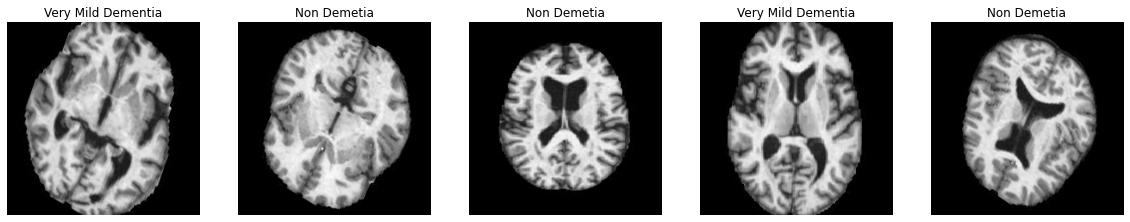

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [5]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 3s 0us/step


In [6]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [7]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [ ]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [8]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [16]:
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRICS = [
      tensorflow.keras.metrics.AUC(name = 'auc'),
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
        f1_score,
          ]
model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

In [10]:
# Defining Callbacks

filepath = '/content/drive/MyDrive/ML_Course/best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 1.3656 - auc: 0.7838 - accuracy: 0.7631 - precision: 0.5293 - recall: 0.4717 - f1_score: 0.4966
Epoch 1: val_auc improved from -inf to 0.69721, saving model to /content/drive/MyDrive/ML_Course/best_weights.hdf5
33/33 [==============================] - 147s 4s/step - loss: 1.3656 - auc: 0.7838 - accuracy: 0.7631 - precision: 0.5293 - recall: 0.4717 - f1_score: 0.4966 - val_loss: 7.4697 - val_auc: 0.6972 - val_accuracy: 0.7571 - val_precision: 0.5142 - val_recall: 0.5132 - val_f1_score: 0.5138
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 1.1301 - auc: 0.8277 - accuracy: 0.7895 - precision: 0.5877 - recall: 0.5288 - f1_score: 0.5600
Epoch 2: val_auc did not improve from 0.69721
33/33 [==============================] - 57s 2s/step - loss: 1.1301 - auc: 0.8277 - accuracy: 0.7895 - precision: 0.5877 - recall: 0.5288 - f1_score: 0.5600 - val_loss: 2.7959 - val_auc: 0.6820 - val_accuracy: 0.7380 - val_

### MODEL EVALUATION

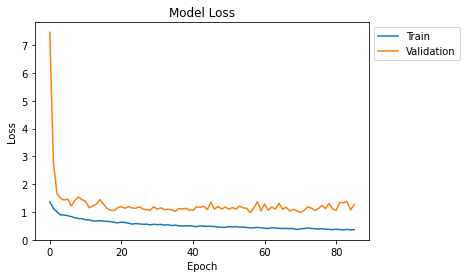

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

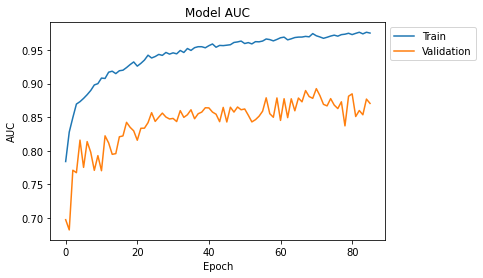

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [19]:
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRICS = [
      tensorflow.keras.metrics.AUC(name = 'auc'),
      tensorflow.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
        f1_score,
          ]
model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

In [20]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical')

Found 1279 images belonging to 4 classes.


In [ ]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

40/40 [==============================] - 22s 181ms/step - loss: 0.9981 - auc: 0.8933 - accuracy: 0.8329 - precision: 0.6718 - recall: 0.6482 - f1_score: 0.6596


[0.9981439113616943,
 0.8933312892913818,
 0.8328772187232971,
 0.6717990040779114,
 0.6481626033782959,
 0.6595860719680786]

1/1 [==============================] - 0s 31ms/step
100.0 % chances are there that the image is [2]


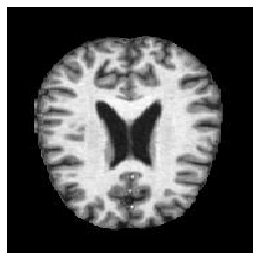

In [ ]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is', classes)

1/1 [==============================] - 0s 33ms/step
97.47 % chances are there that the image is class [0]


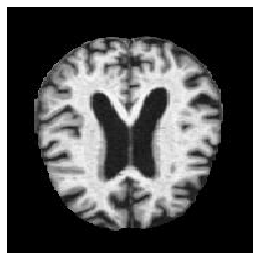

In [ ]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

1/1 [==============================] - 0s 31ms/step
97.24 % chances are there that the image is class [1]


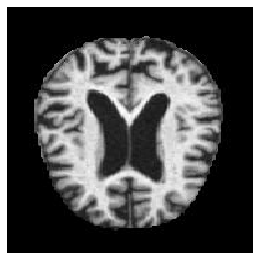

In [ ]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

1/1 [==============================] - 0s 31ms/step
76.84 % chances are there that the image is class [3]


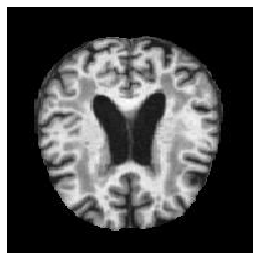

In [ ]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

#Confusion Matrix

In [18]:
model.load_weights('/content/drive/MyDrive/ML_Course/best_weights.hdf5')

In [22]:
true_classes = test_dataset.classes
class_indices = test_dataset.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preds = model.predict(test_dataset)
pred_classes = np.argmax(preds, axis=1)

40/40 [==============================] - 7s 111ms/step


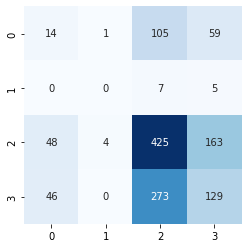

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_dataset.class_indices.keys()

def plot_heatmap(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
    )

plt.figure()
plot_heatmap(true_classes, pred_classes)    

plt.show()

#Another Dataset

In [ ]:
model.load_weights('/content/drive/MyDrive/ML_Course/best_weights.hdf5')

In [24]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 28.0M/28.0M [00:02<00:00, 22.8MB/s]
100% 28.0M/28.0M [00:02<00:00, 13.3MB/s]


In [25]:
import zipfile
local_zip = '/content/alzheimer-mri-dataset.zip'
data = zipfile.ZipFile(local_zip, 'r')
data.extractall('/content/Dataset2')
data.close()

In [26]:
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [29]:
# Test Data 

test_dataset2  = test_datagen.flow_from_directory(directory = '/content/Dataset2/Dataset',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical')

Found 6400 images belonging to 4 classes.


In [30]:
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRICS = [
      tensorflow.keras.metrics.AUC(name = 'auc'),
      tensorflow.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
        f1_score,
          ]
model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

50/50 [==============================] - 37s 409ms/step - loss: 0.9460 - auc: 0.9057 - accuracy: 0.8503 - precision: 0.7048 - recall: 0.6902 - f1_score: 0.6973


[0.9459766149520874,
 0.9056864976882935,
 0.8502734303474426,
 0.704802930355072,
 0.6901562213897705,
 0.6973479986190796]

1/1 [==============================] - 0s 31ms/step
97.04 % chances are there that the image is class [2]


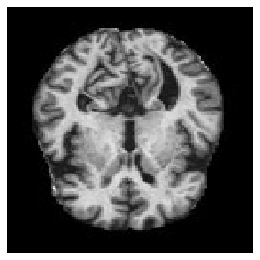

In [ ]:
# Test Case 1: Non-Dementia

dic = test_dataset2.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Dataset/Non_Demented/non_1013.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

1/1 [==============================] - 0s 70ms/step
99.91 % chances are there that the image is class [0]


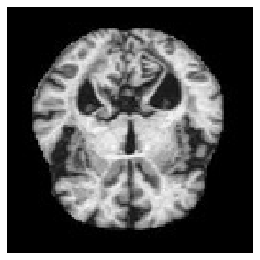

In [ ]:
# Test Case 2: Mild Demented

dic = test_dataset2.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Dataset/Mild_Demented/mild_223.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

1/1 [==============================] - 0s 34ms/step
52.25 % chances are there that the image is class [1]


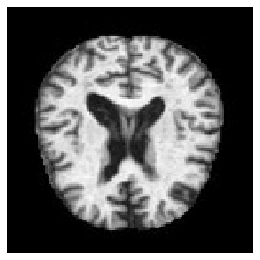

In [ ]:
# Test Case 3: Moderate Demented

dic = test_dataset2.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Dataset/Moderate_Demented/moderate_58.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

1/1 [==============================] - 0s 32ms/step
99.25 % chances are there that the image is class [3]


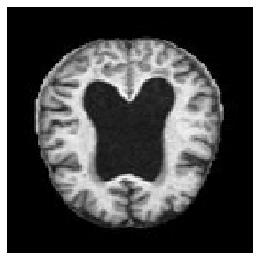

In [ ]:
# Test Case 4: Very Mild Demented

dic = test_dataset2.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Alzheimer_s Dataset/Dataset/Very_Mild_Demented/verymild_101.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

#Confusion Matrix

In [ ]:
model.load_weights('/content/drive/MyDrive/ML_Course/best_weights.hdf5')

In [32]:
true_classes = test_dataset2.classes
class_indices = test_dataset2.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preds = model.predict(test_dataset2)
pred_classes = np.argmax(preds, axis=1)

200/200 [==============================] - 27s 114ms/step


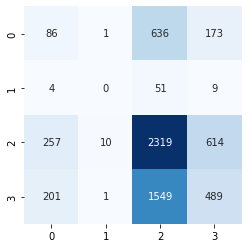

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_dataset2.class_indices.keys()

def plot_heatmap(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
    )

plt.figure()
plot_heatmap(true_classes, pred_classes)    

plt.show()